In [1]:
import pandas as pd 
import numpy as np

import matplotlib as mpl #Used for controlling color import matplotlib.colors #Used for controlling color as well import matplotlib.pyplot as plt import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import seaborn as sns;# sns.set()

import scipy.signal as sg 
from scipy.signal import argrelextrema
from scipy import stats

import xarray as xr

import os
import glob

import time 
from math import *

import matplotlib.ticker as mticker

from datetime import datetime,timezone 
import dateutil.tz as tz

from pysolar import solar

import math

from datetime import datetime, timedelta
from scipy.stats import kendalltau

from sklearn.metrics import r2_score

from scipy.stats import pearsonr


import itertools
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
from matplotlib.colors import LogNorm

In [2]:
df_cod = pd.read_csv('/Users/svisaga/OneDrive - UW-Madison/hsrl_cirrus_pbl_files/02_cirrus_stat_figures/2019_cirrus_v2025_no50lcfilter.csv')
df_cod['Datetime_LT'] = pd.to_datetime(df_cod['Datetime_LT'])
df_cod['Datetime_UTC'] = df_cod['Datetime_LT'].dt.tz_convert('UTC')

df_cod['LC'] = df_cod['low_cld']
df_cod = df_cod[['year', 'month_LT','day_LT','hour_LT','Datetime_UTC', 'Datetime_LT','LC','od_mean','season','cld_top', 'cld_bot']]
df_cod['cld_tck'] = df_cod['cld_top'] - df_cod['cld_bot']

In [3]:
cod_spn = df_cod
cod_spn = cod_spn.replace(0, np.nan)

cod_spn['day'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.day
cod_spn['mon'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.month

In [4]:
cod_spn[((cod_spn['LC']=='Y') & 
    (cod_spn['cld_bot'].isnull())
    )]

,year,month_LT,day_LT,hour_LT,Datetime_UTC,Datetime_LT,LC,od_mean,season,cld_top,cld_bot,cld_tck,day,mon
0,2019,1,1,8,2019-01-01 00:00:00+00:00,2019-01-01 08:00:00+08:00,Y,NaN,DJF,NaN,NaN,NaN,1,1
1,2019,1,1,8,2019-01-01 00:05:00+00:00,2019-01-01 08:05:00+08:00,Y,NaN,DJF,NaN,NaN,NaN,1,1
2,2019,1,1,8,2019-01-01 00:10:00+00:00,2019-01-01 08:10:00+08:00,Y,NaN,DJF,NaN,NaN,NaN,1,1
3,2019,1,1,8,2019-01-01 00:15:00+00:00,2019-01-01 08:15:00+08:00,Y,NaN,DJF,NaN,NaN,NaN,1,1
4,2019,1,1,8,2019-01-01 00:20:00+00:00,2019-01-01 08:20:00+08:00,Y,NaN,DJF,NaN,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46326,2019,12,31,16,2019-12-31 08:05:00+00:00,2019-12-31 16:05:00+08:00,Y,NaN,DJF,NaN,NaN,NaN,31,12
46327,2019,12,31,16,2019-12-31 08:10:00+00:00,2019-12-31 16:10:00+08:00,Y,NaN,DJF,NaN,NaN,NaN,31,12
46328,2019,12,31,16,2019-12-31 08:15:00+00:00,2019-12-31 16:15:00+08:00,Y,NaN,DJF,NaN,NaN,NaN,31,12
46329,2019,12,31,16,2019-12-31 08:20:00+00:00,2019-12-31 16:20:00+08:00,Y,NaN,DJF,NaN,NaN,NaN,31,12


In [5]:
#updated part based on 02_02_cirrus_stat_allpts
cod_spn.loc[(cod_spn['LC'] == 'N') & (cod_spn['cld_bot']<=4000), 'low_cld'] = 'Y'

cod_spn.loc[cod_spn['LC'] == 'Y', 'od_mean'] = np.nan
cod_spn.loc[cod_spn['LC'] == 'Y', 'cld_top'] = np.nan
cod_spn.loc[cod_spn['LC'] == 'Y', 'cld_bot'] = np.nan

cod_spn['cld_top'] = cod_spn['cld_top']/1000
cod_spn['cld_bot'] = cod_spn['cld_bot']/1000
cod_spn['cld_tck'] = cod_spn['cld_top'] - cod_spn['cld_bot']


In [6]:
cod_spn = cod_spn.drop_duplicates()

In [7]:
#OLD

#we see the cld_bot and cld_tck, then classify as thin or opaque
cod_spn.loc[(
    (cod_spn['LC'] == 'N') &
    (cod_spn['cld_bot'] >= 0) & (cod_spn['cld_tck'] >= 0) &
    (cod_spn['od_mean'] > 0) & (cod_spn['od_mean'] <0.3)
    ), 'od_group'] = 'thin'

cod_spn.loc[(
    (cod_spn['LC'] == 'N') &
    (cod_spn['cld_bot'] >= 0) & (cod_spn['cld_tck'] >= 0) &
    (cod_spn['od_mean'] >= 0.3) 
    ), 'od_group'] = 'opaque'

######################################################################################
#set up for attenuated case when we see low cloud but cannot say the cld_bot value
cod_spn.loc[(
    (cod_spn['LC']=='Y') & 
    (cod_spn['cld_bot'].isnull())
    ), 'od_group'] = 'atten'
cod_spn.loc[(
    (cod_spn['LC']=='Y') & 
    (cod_spn['cld_bot'].isnull())
    ), 'LC'] = 'N' #we will consider it now as Attenuating case, so not a Low Cloud Case
cod_spn.loc[(
    (cod_spn['LC']=='Y') & 
    (cod_spn['cld_bot'].isnull())
    ), 'od_mean'] = np.nan #we will consider it now as Attenuating case, so no od_mean

######################################################################################
#attenuated case, with cld_bot, no cld_top and no od_mean value
#cod_spn.loc[(
#    (cod_spn['LC'] == 'N') &
#    (cod_spn['cld_bot']>0) & (cod_spn['cld_top'].isnull()) &
#    (cod_spn['od_mean'].isnull()) 
#   ), 'od_group'] = 'atten'
cod_spn.loc[(
    (cod_spn['LC'] == 'N') &
    (cod_spn['cld_bot']>0) & (cod_spn['cld_top'].isnull()) 
   ), 'od_group'] = 'atten'
#attenuated case, with cld_bot, no cld_top but with od_mean value
######################################################################################
#clear cases
cod_spn.loc[(
    (cod_spn['LC'] == 'N') &
    (cod_spn['cld_bot'].isnull()) & (cod_spn['cld_top'].isnull()) #&
    #(cod_spn['od_mean'].isnull()) 
    ), 'od_group'] = 'clear'

######################################################################################
cod_spn.loc[(
    (cod_spn['LC'] == 'Y')
    ), 'od_group'] = 'LC'


In [8]:
cod_spn['day_LT'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.day
cod_spn['month_LT'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.month
cod_spn['year_LT'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.year
fin = cod_spn

fin['mon_day_yr'] = fin['month_LT'].astype(str) + '-' + fin['day_LT'].astype(str) + '-' + fin['year_LT'].astype(str)

In [9]:
mfin = fin
mfin = mfin[mfin['od_group']!="clear_no"]
mfin = mfin[mfin['od_group']!="atten"]

In [10]:
mfin = fin[fin['Datetime_LT']<'2020-07-01 00:00:00+08:00']
mfin = mfin[mfin['od_group']!="clear_no"]

mfin = mfin[mfin['od_group']!="clear_no"]

In [11]:
glued_data = pd.DataFrame()
for file_name in glob.glob('/Users/svisaga/OneDrive - UW-Madison/hsrl_cirrus_pbl_files/all/pblh/pblh_hsrl/*BLH_final.csv'):
    x = pd.read_csv(file_name, low_memory=False)
    glued_data = pd.concat([glued_data,x],axis=0)
glued_data = glued_data[['time','0']]

df = glued_data
df.columns = ['time','value']
df

,time,value
0,2019-04-13 22:00:00,NaN
1,2019-04-13 22:01:00,NaN
2,2019-04-13 22:02:00,NaN
3,2019-04-13 22:03:00,NaN
4,2019-04-13 22:04:00,NaN
...,...,...
760,2019-04-15 10:55:00,NaN
761,2019-04-15 10:56:00,NaN
762,2019-04-15 10:57:00,NaN
763,2019-04-15 10:58:00,NaN


In [12]:
df['time_UTC'] = pd.to_datetime(df.time).dt.tz_localize('UTC')
df['time_LT']  = df['time_UTC'].dt.tz_convert('Asia/Manila')
df['mon_LT'] = pd.to_datetime(df['time_LT']).dt.month
df['day_LT'] = pd.to_datetime(df['time_LT']).dt.day
df['hr_LT'] = pd.to_datetime(df['time_LT']).dt.hour
df['mon_day'] = df['mon_LT'].astype(int).astype(str) + '-' + df['day_LT'].astype(int).astype(str)
df = df.reset_index()
df_backup = df
df_proc = df_backup
df_proc.set_index('time_LT', inplace=True)
df = df_proc.resample('1T').mean()
df = df.reset_index()

df['hr_LT'] = pd.to_datetime(df['time_LT']).dt.hour
df['min'] = pd.to_datetime(df['time_LT']).dt.minute
df = df[df['hr_LT']>=0]

df.loc[((df['mon_LT'] == 12) | (df['mon_LT'] <= 2)), 'seas'] = 'DJF' 
df.loc[((df['mon_LT'] >= 3) & (df['mon_LT'] <= 5)), 'seas'] = 'MAM'
df.loc[((df['mon_LT'] >= 6) & (df['mon_LT'] <= 8)), 'seas'] = 'JJA' 
df.loc[((df['mon_LT'] >= 9) & (df['mon_LT'] <= 11)), 'seas'] = 'SON' 
#df.loc[((df['seas'] == 'DJF')) & ((df['hr_LT'] <= 8)), 'value'] = np.nan
df['axis-hour'] = pd.to_datetime('2019-01-01 ' + df['hr_LT'].astype(int).astype(str) + ':' + df['min'].astype(int).astype(str)+ ':00' , format='%Y-%m-%d %H:%M:%S')


df.loc[(df['value']<500), 'value'] =np.nan 

#15:59 to 16:16
df.loc[(df['value'] < 550) & ((df['hr_LT'] == 15) & (df['min']==59)), 'value'] = np.nan
df.loc[(df['value'] < 550) & ((df['hr_LT'] == 16) & (df['min']>=0) & (df['min']<=16)), 'value'] = np.nan


df['Datetime_LT']= df['time_LT']

/var/folders/n8/_5lr4ytd691827bdc5_mtzyc0000gq/T/ipykernel_43007/592059644.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_proc.resample('1T').mean()


In [13]:
mfin = fin[fin['Datetime_LT']<'2020-07-01 00:00:00+08:00']
mfin = mfin[['Datetime_LT', 'Datetime_UTC', 'season','od_mean', 'od_group', 'month_LT', 'year_LT', 'mon_day_yr']]
df_pbl_cod_spn = pd.merge(df,mfin,on=['Datetime_LT'], how='inner')

In [14]:
df_pbl_cod_spn['mon_LT'] = pd.to_datetime(df_pbl_cod_spn['time_LT']).dt.month
df_pbl_cod_spn['day_LT'] = pd.to_datetime(df_pbl_cod_spn['time_LT']).dt.day
df_pbl_cod_spn['hr_LT'] = pd.to_datetime(df_pbl_cod_spn['time_LT']).dt.hour
df_pbl_cod_spn

,time_LT,index,value,mon_LT,day_LT,hr_LT,min,seas,axis-hour,Datetime_LT,Datetime_UTC,season,od_mean,od_group,month_LT,year_LT,mon_day_yr
0,2019-01-04 06:25:00+08:00,25.0,NaN,1,4,6,25,DJF,2019-01-01 06:25:00,2019-01-04 06:25:00+08:00,2019-01-03 22:25:00+00:00,DJF,0.030665,thin,1,2019,1-4-2019
1,2019-01-04 06:30:00+08:00,30.0,NaN,1,4,6,30,DJF,2019-01-01 06:30:00,2019-01-04 06:30:00+08:00,2019-01-03 22:30:00+00:00,DJF,NaN,clear,1,2019,1-4-2019
2,2019-01-04 06:35:00+08:00,35.0,NaN,1,4,6,35,DJF,2019-01-01 06:35:00,2019-01-04 06:35:00+08:00,2019-01-03 22:35:00+00:00,DJF,0.056822,thin,1,2019,1-4-2019
3,2019-01-04 06:40:00+08:00,40.0,NaN,1,4,6,40,DJF,2019-01-01 06:40:00,2019-01-04 06:40:00+08:00,2019-01-03 22:40:00+00:00,DJF,0.044437,thin,1,2019,1-4-2019
4,2019-01-04 06:45:00+08:00,45.0,NaN,1,4,6,45,DJF,2019-01-01 06:45:00,2019-01-04 06:45:00+08:00,2019-01-03 22:45:00+00:00,DJF,0.028776,thin,1,2019,1-4-2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45566,2019-12-28 17:10:00+08:00,670.0,NaN,12,28,17,10,DJF,2019-01-01 17:10:00,2019-12-28 17:10:00+08:00,2019-12-28 09:10:00+00:00,DJF,NaN,clear,12,2019,12-28-2019
45567,2019-12-28 17:15:00+08:00,675.0,NaN,12,28,17,15,DJF,2019-01-01 17:15:00,2019-12-28 17:15:00+08:00,2019-12-28 09:15:00+00:00,DJF,NaN,clear,12,2019,12-28-2019
45568,2019-12-28 17:20:00+08:00,680.0,NaN,12,28,17,20,DJF,2019-01-01 17:20:00,2019-12-28 17:20:00+08:00,2019-12-28 09:20:00+00:00,DJF,NaN,clear,12,2019,12-28-2019
45569,2019-12-28 17:25:00+08:00,685.0,NaN,12,28,17,25,DJF,2019-01-01 17:25:00,2019-12-28 17:25:00+08:00,2019-12-28 09:25:00+00:00,DJF,NaN,clear,12,2019,12-28-2019


In [15]:
df_pbl_cod_spn.columns

Index(['time_LT', 'index', 'value', 'mon_LT', 'day_LT', 'hr_LT', 'min', 'seas',
       'axis-hour', 'Datetime_LT', 'Datetime_UTC', 'season', 'od_mean',
       'od_group', 'month_LT', 'year_LT', 'mon_day_yr'],
      dtype='object')

In [16]:
# do the Datetime_LTformerging

df_pbl_cod_spn['Datetime_LTformerging'] = pd.to_datetime('2019-' 
                                                         + df_pbl_cod_spn['mon_LT'].astype(int).astype(str)
                                                         + '-'
                                                         + df_pbl_cod_spn['day_LT'].astype(int).astype(str)
                                                         + ' 00:00:00' , format='%Y-%m-%d %H:%M:%S')
df_pbl_cod_spn

,time_LT,index,value,mon_LT,day_LT,hr_LT,min,seas,axis-hour,Datetime_LT,Datetime_UTC,season,od_mean,od_group,month_LT,year_LT,mon_day_yr,Datetime_LTformerging
0,2019-01-04 06:25:00+08:00,25.0,NaN,1,4,6,25,DJF,2019-01-01 06:25:00,2019-01-04 06:25:00+08:00,2019-01-03 22:25:00+00:00,DJF,0.030665,thin,1,2019,1-4-2019,2019-01-04
1,2019-01-04 06:30:00+08:00,30.0,NaN,1,4,6,30,DJF,2019-01-01 06:30:00,2019-01-04 06:30:00+08:00,2019-01-03 22:30:00+00:00,DJF,NaN,clear,1,2019,1-4-2019,2019-01-04
2,2019-01-04 06:35:00+08:00,35.0,NaN,1,4,6,35,DJF,2019-01-01 06:35:00,2019-01-04 06:35:00+08:00,2019-01-03 22:35:00+00:00,DJF,0.056822,thin,1,2019,1-4-2019,2019-01-04
3,2019-01-04 06:40:00+08:00,40.0,NaN,1,4,6,40,DJF,2019-01-01 06:40:00,2019-01-04 06:40:00+08:00,2019-01-03 22:40:00+00:00,DJF,0.044437,thin,1,2019,1-4-2019,2019-01-04
4,2019-01-04 06:45:00+08:00,45.0,NaN,1,4,6,45,DJF,2019-01-01 06:45:00,2019-01-04 06:45:00+08:00,2019-01-03 22:45:00+00:00,DJF,0.028776,thin,1,2019,1-4-2019,2019-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45566,2019-12-28 17:10:00+08:00,670.0,NaN,12,28,17,10,DJF,2019-01-01 17:10:00,2019-12-28 17:10:00+08:00,2019-12-28 09:10:00+00:00,DJF,NaN,clear,12,2019,12-28-2019,2019-12-28
45567,2019-12-28 17:15:00+08:00,675.0,NaN,12,28,17,15,DJF,2019-01-01 17:15:00,2019-12-28 17:15:00+08:00,2019-12-28 09:15:00+00:00,DJF,NaN,clear,12,2019,12-28-2019,2019-12-28
45568,2019-12-28 17:20:00+08:00,680.0,NaN,12,28,17,20,DJF,2019-01-01 17:20:00,2019-12-28 17:20:00+08:00,2019-12-28 09:20:00+00:00,DJF,NaN,clear,12,2019,12-28-2019,2019-12-28
45569,2019-12-28 17:25:00+08:00,685.0,NaN,12,28,17,25,DJF,2019-01-01 17:25:00,2019-12-28 17:25:00+08:00,2019-12-28 09:25:00+00:00,DJF,NaN,clear,12,2019,12-28-2019,2019-12-28


In [17]:
df_pbl_cod_spn['pblh'] = df_pbl_cod_spn['value']
df_pbl_cod_spn.columns

Index(['time_LT', 'index', 'value', 'mon_LT', 'day_LT', 'hr_LT', 'min', 'seas',
       'axis-hour', 'Datetime_LT', 'Datetime_UTC', 'season', 'od_mean',
       'od_group', 'month_LT', 'year_LT', 'mon_day_yr',
       'Datetime_LTformerging', 'pblh'],
      dtype='object')

In [18]:
df_pbl_cod_spn['mon_day_yr'].nunique()

357

In [19]:
df_pbl_cod_spn.columns


Index(['time_LT', 'index', 'value', 'mon_LT', 'day_LT', 'hr_LT', 'min', 'seas',
       'axis-hour', 'Datetime_LT', 'Datetime_UTC', 'season', 'od_mean',
       'od_group', 'month_LT', 'year_LT', 'mon_day_yr',
       'Datetime_LTformerging', 'pblh'],
      dtype='object')

In [20]:
df_pbl_cod_spn['Datetime_LTformerging']= df_pbl_cod_spn['Datetime_LTformerging'].dt.tz_localize('Asia/Manila')

In [21]:
df_pbl_cod_spn#[df_pbl_cod_spn['mon_LT']>0]

,time_LT,index,value,mon_LT,day_LT,hr_LT,min,seas,axis-hour,Datetime_LT,Datetime_UTC,season,od_mean,od_group,month_LT,year_LT,mon_day_yr,Datetime_LTformerging,pblh
0,2019-01-04 06:25:00+08:00,25.0,NaN,1,4,6,25,DJF,2019-01-01 06:25:00,2019-01-04 06:25:00+08:00,2019-01-03 22:25:00+00:00,DJF,0.030665,thin,1,2019,1-4-2019,2019-01-04 00:00:00+08:00,NaN
1,2019-01-04 06:30:00+08:00,30.0,NaN,1,4,6,30,DJF,2019-01-01 06:30:00,2019-01-04 06:30:00+08:00,2019-01-03 22:30:00+00:00,DJF,NaN,clear,1,2019,1-4-2019,2019-01-04 00:00:00+08:00,NaN
2,2019-01-04 06:35:00+08:00,35.0,NaN,1,4,6,35,DJF,2019-01-01 06:35:00,2019-01-04 06:35:00+08:00,2019-01-03 22:35:00+00:00,DJF,0.056822,thin,1,2019,1-4-2019,2019-01-04 00:00:00+08:00,NaN
3,2019-01-04 06:40:00+08:00,40.0,NaN,1,4,6,40,DJF,2019-01-01 06:40:00,2019-01-04 06:40:00+08:00,2019-01-03 22:40:00+00:00,DJF,0.044437,thin,1,2019,1-4-2019,2019-01-04 00:00:00+08:00,NaN
4,2019-01-04 06:45:00+08:00,45.0,NaN,1,4,6,45,DJF,2019-01-01 06:45:00,2019-01-04 06:45:00+08:00,2019-01-03 22:45:00+00:00,DJF,0.028776,thin,1,2019,1-4-2019,2019-01-04 00:00:00+08:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45566,2019-12-28 17:10:00+08:00,670.0,NaN,12,28,17,10,DJF,2019-01-01 17:10:00,2019-12-28 17:10:00+08:00,2019-12-28 09:10:00+00:00,DJF,NaN,clear,12,2019,12-28-2019,2019-12-28 00:00:00+08:00,NaN
45567,2019-12-28 17:15:00+08:00,675.0,NaN,12,28,17,15,DJF,2019-01-01 17:15:00,2019-12-28 17:15:00+08:00,2019-12-28 09:15:00+00:00,DJF,NaN,clear,12,2019,12-28-2019,2019-12-28 00:00:00+08:00,NaN
45568,2019-12-28 17:20:00+08:00,680.0,NaN,12,28,17,20,DJF,2019-01-01 17:20:00,2019-12-28 17:20:00+08:00,2019-12-28 09:20:00+00:00,DJF,NaN,clear,12,2019,12-28-2019,2019-12-28 00:00:00+08:00,NaN
45569,2019-12-28 17:25:00+08:00,685.0,NaN,12,28,17,25,DJF,2019-01-01 17:25:00,2019-12-28 17:25:00+08:00,2019-12-28 09:25:00+00:00,DJF,NaN,clear,12,2019,12-28-2019,2019-12-28 00:00:00+08:00,NaN


In [22]:
df_pbl_cod_spn['mon_LT'] = pd.to_datetime(df_pbl_cod_spn['time_LT']).dt.month
df_pbl_cod_spn['day_LT'] = pd.to_datetime(df_pbl_cod_spn['time_LT']).dt.day

In [23]:
df_pbl_cod_spn['mon_day_yr'] = df_pbl_cod_spn['mon_LT'].astype(int).astype(str) + '-' + df_pbl_cod_spn['day_LT'].astype(int).astype(str) + '-2019'



In [24]:
df_pbl_cod_spn

,time_LT,index,value,mon_LT,day_LT,hr_LT,min,seas,axis-hour,Datetime_LT,Datetime_UTC,season,od_mean,od_group,month_LT,year_LT,mon_day_yr,Datetime_LTformerging,pblh
0,2019-01-04 06:25:00+08:00,25.0,NaN,1,4,6,25,DJF,2019-01-01 06:25:00,2019-01-04 06:25:00+08:00,2019-01-03 22:25:00+00:00,DJF,0.030665,thin,1,2019,1-4-2019,2019-01-04 00:00:00+08:00,NaN
1,2019-01-04 06:30:00+08:00,30.0,NaN,1,4,6,30,DJF,2019-01-01 06:30:00,2019-01-04 06:30:00+08:00,2019-01-03 22:30:00+00:00,DJF,NaN,clear,1,2019,1-4-2019,2019-01-04 00:00:00+08:00,NaN
2,2019-01-04 06:35:00+08:00,35.0,NaN,1,4,6,35,DJF,2019-01-01 06:35:00,2019-01-04 06:35:00+08:00,2019-01-03 22:35:00+00:00,DJF,0.056822,thin,1,2019,1-4-2019,2019-01-04 00:00:00+08:00,NaN
3,2019-01-04 06:40:00+08:00,40.0,NaN,1,4,6,40,DJF,2019-01-01 06:40:00,2019-01-04 06:40:00+08:00,2019-01-03 22:40:00+00:00,DJF,0.044437,thin,1,2019,1-4-2019,2019-01-04 00:00:00+08:00,NaN
4,2019-01-04 06:45:00+08:00,45.0,NaN,1,4,6,45,DJF,2019-01-01 06:45:00,2019-01-04 06:45:00+08:00,2019-01-03 22:45:00+00:00,DJF,0.028776,thin,1,2019,1-4-2019,2019-01-04 00:00:00+08:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45566,2019-12-28 17:10:00+08:00,670.0,NaN,12,28,17,10,DJF,2019-01-01 17:10:00,2019-12-28 17:10:00+08:00,2019-12-28 09:10:00+00:00,DJF,NaN,clear,12,2019,12-28-2019,2019-12-28 00:00:00+08:00,NaN
45567,2019-12-28 17:15:00+08:00,675.0,NaN,12,28,17,15,DJF,2019-01-01 17:15:00,2019-12-28 17:15:00+08:00,2019-12-28 09:15:00+00:00,DJF,NaN,clear,12,2019,12-28-2019,2019-12-28 00:00:00+08:00,NaN
45568,2019-12-28 17:20:00+08:00,680.0,NaN,12,28,17,20,DJF,2019-01-01 17:20:00,2019-12-28 17:20:00+08:00,2019-12-28 09:20:00+00:00,DJF,NaN,clear,12,2019,12-28-2019,2019-12-28 00:00:00+08:00,NaN
45569,2019-12-28 17:25:00+08:00,685.0,NaN,12,28,17,25,DJF,2019-01-01 17:25:00,2019-12-28 17:25:00+08:00,2019-12-28 09:25:00+00:00,DJF,NaN,clear,12,2019,12-28-2019,2019-12-28 00:00:00+08:00,NaN


In [25]:
mfin2 = df_pbl_cod_spn.groupby('mon_day_yr').agg({"od_mean": "median", "pblh":  "max"})
mfin2 = mfin2.reset_index()

In [26]:
mfin2 = mfin2[mfin2['pblh']>0]

In [27]:
mfin2['mon'] = pd.to_datetime(mfin2['mon_day_yr']).dt.month
mfin2.reset_index()

,index,mon_day_yr,od_mean,pblh,mon
0,5,1-15-2019,0.163687,1765.879049,1
1,11,1-21-2019,0.681276,1658.125898,1
2,22,1-4-2019,0.061508,2171.395357,1
3,28,10-1-2019,0.290391,1127.435053,10
4,29,10-10-2019,0.069018,1616.538902,10
5,32,10-13-2019,0.282055,1799.856685,10
6,49,10-29-2019,0.880826,962.988062,10
7,50,10-3-2019,0.134833,1587.155637,10
8,53,10-4-2019,0.141544,1105.330442,10
9,54,10-5-2019,0.382887,1017.752626,10


In [28]:
mfin2.loc[((mfin2['mon'] == 12) | (mfin2['mon'] <= 2)), 'seas'] = 'DJF' 
mfin2.loc[((mfin2['mon'] >= 3) & (mfin2['mon'] <= 5)), 'seas'] = 'MAM'
mfin2.loc[((mfin2['mon'] >= 6) & (mfin2['mon'] <= 8)), 'seas'] = 'JJA' 
mfin2.loc[((mfin2['mon'] >= 9) & (mfin2['mon'] <= 11)), 'seas'] = 'SON' 


df_DJF = mfin2[(mfin2['seas']=='DJF')]
df_MAM = mfin2[(mfin2['seas']=='MAM')]
df_JJA = mfin2[(mfin2['seas']=='JJA')]
df_SON = mfin2[(mfin2['seas']=='SON')]

d) y = -854.1157341446191x + 1798.763675120775
d) r = -0.41724805369291296,pvalue:0.004835168263099236
d) 44,44


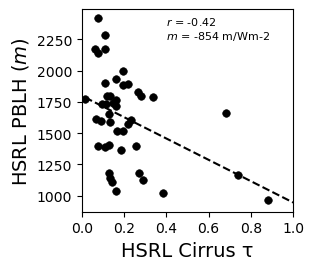

In [29]:
a4_dims = (15,10)
fig = plt.figure(figsize=a4_dims)
gs = fig.add_gridspec(3, 4,wspace=0.5,hspace=0.4)

###################################################
sub_ = mfin2
sub_ = sub_[(sub_['od_mean'] >= 0) & (sub_['pblh'] >= 0)]
tt = sub_
aa_x = np.array(tt['od_mean'])
aa_y = np.array(tt['pblh'])
x_a=aa_x
y_a=aa_y
xaa = x_a[~np.isnan(x_a)]
yaa = y_a[~np.isnan(y_a)]

x_new = np.linspace(xaa.min(), 1, 1000)
slope_a, intercept_a, r_value_a, p_value_a, std_err_a = stats.linregress(x_a,y_a)
corr, _ = pearsonr(xaa,yaa)
print(f'd) y = {slope_a:02}x + {intercept_a:02}')
print(f'd) r = {corr:02},pvalue:{_:02}')
print(f'd) {len(xaa)},{len(yaa)}')
###############################
ax = fig.add_subplot(gs[1, 0])
sns.scatterplot(x="od_mean", y="pblh", facecolor='k', edgecolor='k', 
                      data=df_DJF,marker="o" ,s=30,  legend=False)
sns.scatterplot(x="od_mean", y="pblh", facecolor='k', edgecolor='k', 
                      data=df_MAM,marker="o" ,s=30,  legend=False)
sns.scatterplot(x="od_mean", y="pblh", facecolor='k', edgecolor='k', 
                      data=df_JJA,marker="o" ,s=30,  legend=False)
sns.scatterplot(x="od_mean", y="pblh", facecolor='k', edgecolor='k', 
                      data=df_SON,marker="o" ,s=30,  legend=False)
plt.plot(x_new,slope_a*x_new + intercept_a,  color='black', linestyle='--')


plt.ylabel('HSRL PBLH ($m$)', fontsize=14)
plt.xlabel('HSRL Cirrus ' + chr(964) , fontsize=14)
plt.xlim(0,1)
ax.text(0.4, 0.85,  '$r$ = -0.42\n$m$ = -854 m/Wm-2', fontsize=8, color='k', transform=ax.transAxes)


output_filename = 'Figure7_JGRPaper.png'
plt.savefig(output_filename, dpi= 300, bbox_inches='tight')


In [30]:
mfin2[mfin2['pblh']<1300]

,mon_day_yr,od_mean,pblh,mon,seas
28,10-1-2019,0.290391,1127.435053,10,SON
49,10-29-2019,0.880826,962.988062,10,SON
53,10-4-2019,0.141544,1105.330442,10,SON
54,10-5-2019,0.382887,1017.752626,10,SON
72,11-21-2019,0.741137,1164.338448,11,SON
206,5-10-2019,0.128530,1182.700920,5,MAM
277,7-20-2019,0.272683,1183.800393,7,JJA
281,7-24-2019,0.133033,1143.035821,7,JJA
282,7-25-2019,0.160582,1038.138816,7,JJA
